## Project: Analysing Currency Trends (based on Bitcoin, USD, GBP in relation to Euro).

***

### 1. Data Collection

***

Importing libraries.

In [1]:
import yfinance as yf
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager
import warnings
import logging
from fuctions import *
#from fuctions import flattenColumns

The Yahoo Finance API is known to have several limitations. Error messages returned by the API provide information on correctly fetching specific data. The most suitable data for the project was selected based on a particular time range and granularity. This selection was influenced by data availability and demand. Attempts to retrieve large volumes of data across different periods to expand the dataset were unsuccessful due to strict API limitations. The constraints dictate that data must be retrieved from today's date and are dependent on specific API parameters. Consequently, the data was broken into smaller chunks to prevent any loss of information.

A function was added to log any warnings that may occur during the execution of the script. This function logs warnings to a file, facilitating debugging in case any warnings arise.

In [2]:
warnings.showwarning = logWarning

Here is a few examples entry from the log file to help understand the syntax of the Yahoo Finance API interface:

```log File
YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=2y) (Yahoo error = "Invalid input - interval=50m is not supported. Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]")')

YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=2y) (Yahoo error = "15m data not available for startTime=1671481488 and endTime=1734553488. The requested range must be within the last 60 days.")')
```

***

Downloading exchange rate USD to EUR represented by USDEUR=X and GBP to EUR represented by GBPEUR=X.

In [3]:
# Download USD/EUR and GBP/EUR exchange rates
eur2yraw = yf.download(['USDEUR=X', 'GBPEUR=X'], period='2y', interval='60m', group_by='ticker')
eur5yraw = yf.download(['USDEUR=X', 'GBPEUR=X'], period='5y', interval='1d', group_by='ticker')
eur5draw = yf.download(['USDEUR=X', 'GBPEUR=X'], period='5d', interval='5m', group_by='ticker')

eur5draw.head(2)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Ticker                    USDEUR=X                                           \
Price                         Open    High     Low   Close Adj Close Volume   
Datetime                                                                      
2024-12-24 00:00:00+00:00   0.9609  0.9610  0.9608  0.9610    0.9610    0.0   
2024-12-24 00:05:00+00:00   0.9610  0.9611  0.9610  0.9611    0.9611    0.0   

Ticker                    GBPEUR=X                                             
Price                         Open     High     Low    Close Adj Close Volume  
Datetime                                                                       
2024-12-24 00:00:00+00:00  1.20449  1.20458  1.2041  1.20420   1.20420    0.0  
2024-12-24 00:05:00+00:00  1.20455  1.20457  1.2041  1.20455   1.20455    0.0

Downloading exchange rate BTC to EUR represented by BTC-EUR.

In [4]:
# Download BTC-EUR data
btc2yraw = yf.download('BTC-EUR', period='2y', interval='60m')
btc5yraw = yf.download('BTC-EUR', period='5y', interval='1d')
btc5draw = yf.download('BTC-EUR', period='5d', interval='5m')

# For debugging purposes
btc2yraw.head(2)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR
Datetime,,,,,,
2022-12-30 20:00:00,15467.715820,15467.715820,15470.239258,15449.636719,15460.961914,0
2022-12-30 21:00:00,15501.561523,15501.561523,15517.405273,15467.369141,15467.369141,594299904


The data will be saved to separate CSV files, but before doing so, it will be formatted appropriately.

The sequence of columns is being changed first to ensure consistency with other DataFrames.

In [5]:
# Define the list of DataFrames
dataframes = [btc2yraw, btc5yraw, btc5draw]

# Define the desired order for the columns
newOrder = [
    ('Open', 'BTC-EUR'), 
    ('High', 'BTC-EUR'), 
    ('Low', 'BTC-EUR'),
    ('Close', 'BTC-EUR'), 
    ('Adj Close', 'BTC-EUR'), 
    ('Volume', 'BTC-EUR')
]

# Reorder the columns for each DataFrame
formatedDataFrames = []

for df in dataframes:
    # Reorder the columns using the new_order
    formatedDf = df[newOrder]
    formatedDataFrames.append(formatedDf)

btc2yraw, btc5yraw, btc5draw = formatedDataFrames
# For degurging purposes
btc5yraw.head()


Price,Open,High,Low,Close,Adj Close,Volume
Ticker,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR,BTC-EUR
Date,,,,,,
2019-12-30,6635.920410,6653.482422,6490.386719,6510.733887,6510.733887,20420606561
2019-12-31,6512.022949,6537.012207,6392.172363,6411.460449,6411.460449,18866418835
2020-01-01,6412.612793,6469.861816,6420.140137,6417.781738,6417.781738,16548264141
2020-01-02,6419.900391,6425.734863,6206.927734,6252.938477,6252.938477,18620672983
2020-01-03,6252.006348,6634.896973,6187.711426,6581.735840,6581.735840,25190641930


Next, multi-index columns will be flattened into single-level columns, and 'Date' will be renamed to 'Datetime' to ensure consistency with the other datasets.

In [6]:
## List of DataFrames for 2 years, 5 years, and 5 days data
all2y = [eur2yraw, btc2yraw]
all5y = [eur5yraw, btc5yraw]
all5d = [eur5draw, btc5draw]

# Reset index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.reset_index(inplace=True)  # Resets the index for each DataFrame

# Apply flatten_columns function to each DataFrame in all lists
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        flattenColumns(df)
        
# Setting index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.set_index('Datetime', inplace=True)

# For degurging purposes
btc2yraw.head()


,Open_BTC-EUR,High_BTC-EUR,Low_BTC-EUR,Close_BTC-EUR,Adj Close_BTC-EUR,Volume_BTC-EUR
Datetime,,,,,,
2022-12-30 20:00:00,15460.961914,15470.239258,15449.636719,15467.715820,15467.715820,0
2022-12-30 21:00:00,15467.369141,15517.405273,15467.369141,15501.561523,15501.561523,594299904
2022-12-30 22:00:00,15501.586914,15501.586914,15470.601562,15475.168945,15475.168945,77096960
2022-12-30 23:00:00,15473.912109,15485.974609,15466.680664,15479.968750,15479.968750,66200576
2022-12-31 00:00:00,15478.656250,15484.635742,15464.312500,15475.023438,15475.023438,141176832


Finally, the names of the existing columns are being changed.

In [7]:
# Define the new order and column name mapping
rename_dict = {
    'Open_BTC-EUR': 'BTC-EUR_Open',
    'High_BTC-EUR': 'BTC-EUR_High',
    'Low_BTC-EUR': 'BTC-EUR_Low',
    'Close_BTC-EUR': 'BTC-EUR_Close',
    'Adj Close_BTC-EUR': 'BTC-EUR_Adj Close',
    'Volume_BTC-EUR': 'BTC-EUR_Volume'
}

# List of DataFrames to process
dataframes = [btc2yraw, btc5yraw, btc5draw]

# Rename columns and reorder the columns for each DataFrame
for df in dataframes:
    # Rename columns to match newOrder
    df.rename(columns=rename_dict, inplace=True)

# For degurging purposes
btc2yraw.head(3)


,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-EUR_Adj Close,BTC-EUR_Volume
Datetime,,,,,,
2022-12-30 20:00:00,15460.961914,15470.239258,15449.636719,15467.715820,15467.715820,0
2022-12-30 21:00:00,15467.369141,15517.405273,15467.369141,15501.561523,15501.561523,594299904
2022-12-30 22:00:00,15501.586914,15501.586914,15470.601562,15475.168945,15475.168945,77096960


Now is time to save the data.

In [8]:
# Save the data to CSV files
eurToSave = [eur2yraw, eur5yraw, eur5draw]
filenames = ['eur2yraw.csv', 'eur5yraw.csv', 'eur5draw.csv']
for i in range(3):
    eurToSave[i].to_csv(f'data/csv/raw/{filenames[i]}')
print('Data saved to CSV files.')

Data saved to CSV files.


In [9]:
# Save the data to CSV files
btcToSave = [btc2yraw, btc5yraw, btc5draw]
filenames = ['btc2yraw.csv', 'btc5yraw.csv', 'btc5draw.csv']
for i in range(3):
    btcToSave[i].to_csv(f'data/csv/raw/{filenames[i]}')
print('Data saved to CSV files.')


Data saved to CSV files.


***

#### Transferring to the Database.

An SQLite database named currency.db will be created. The data from the CSV files will then be inserted into the tables, with the data flattened to ensure compatibility with the database structure.

The CSV files will be transferred to the SQLite database. 

In [10]:
# Connect to SQLite database (creates file if it doesn't exist)
conn = sqlite3.connect('data/db/currencies.db')

# List of DataFrames and their corresponding table names
dataframes = [(eur2yraw, 'eur2yraw'), (eur5yraw, 'eur5yraw'), (eur5draw, 'eur5draw'), 
              (btc2yraw, 'btc2yraw'), (btc5yraw, 'btc5yraw'), (btc5draw, 'btc5draw')]
# Loop to write each DataFrame to the SQLite database
for df, table_name in dataframes:
    df.to_sql(table_name, conn, if_exists='replace', index=True)
    
# Close the connection to SQLite
conn.close()

print("Data successfully written to SQLite database.")


Data successfully written to SQLite database.


The contents of the database will be checked to identify the tables it contains.

In [11]:
# Connect to the SQLite database
conn = sqlite3.connect('data/db/currencies.db')
cursor = conn.cursor()

# Query to list tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the tables
print("Tables in the database:")
for table in tables:
    print(table[0])

# Close the connection
conn.close()

Tables in the database:
allCurrenciesData2y
allCurrenciesData5y
allCurrenciesData5d
normalisedBasedValue2y
normalisedBasedValue5y
normalisedBasedValue5d
normalisedMinMax2y
normalisedMinMax5y
normalisedMinMax5d
normalisedZscore2y
normalisedZscore5y
normalisedZscore5d
descriptiveStatistics
eur2yraw
eur5yraw
eur5draw
btc2yraw
btc5yraw
btc5draw


A test query will be executed on the database to check its functionality.

In [12]:
# Connect to the SQLite database
conn = sqlite3.connect('data/db/currencies.db')

# Read data from the table into a pandas DataFrame
query = "SELECT * FROM btc5yraw LIMIT 5;"  # Adjust for your table name
df = pd.read_sql(query, conn)
df.set_index('Datetime', inplace=True)

# Display the DataFrame
df

,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-EUR_Adj Close,BTC-EUR_Volume
Datetime,,,,,,
2019-12-30 00:00:00,6635.920410,6653.482422,6490.386719,6510.733887,6510.733887,20420606561
2019-12-31 00:00:00,6512.022949,6537.012207,6392.172363,6411.460449,6411.460449,18866418835
2020-01-01 00:00:00,6412.612793,6469.861816,6420.140137,6417.781738,6417.781738,16548264141
2020-01-02 00:00:00,6419.900391,6425.734863,6206.927734,6252.938477,6252.938477,18620672983
2020-01-03 00:00:00,6252.006348,6634.896973,6187.711426,6581.735840,6581.735840,25190641930


Understanding the collected data is essential. The following columns can be identified:
* Open: Price at the start of the trading period.
* High: Highest price during the trading period.
* Low: Lowest price during the trading period.
* Close: Price at the end of the trading period.
* Adj Close: Close price adjusted for events like splits or dividends (irrelevant in this case).
* Volume: Total amount of the asset traded during the period.


***

### 2. Data Cleaning

The choice was made to analyse OHLC data (Open, High, Low, Close), with the analysis focused on the Close price. This provides a comprehensive view of price movements, which is crucial for identifying market trends and making informed trading decisions.

Other data, such as volume or adjusted close, will be omitted, as they are less relevant for understanding price action and trend analysis. Upon examining the data, it became clear that the Adj Close column contains the same values as the Close column, and the Volume column is empty.

Formatting Data Frames for easier manipulation 

The columns not needed for the analysis were removed. The 'Adj Close' and 'Volume' columns will be removed from the DataFrames.

In [13]:
# Columns to drop (targeting columns that have '_Adj Close' or '_Volume' suffixes)
columnsToDrop = ['_Adj Close', '_Volume']

# List of DataFrames for each asset
dfColumnsDroppedList = [eur2yraw, btc2yraw, eur5yraw, btc5yraw, eur5draw, btc5draw]

# Iterate over each DataFrame and drop columns that contain '_Adj Close' or '_Volume'
for df in dfColumnsDroppedList:
    df.drop([col for col in df.columns if any(drop in col for drop in columnsToDrop)], axis=1, inplace=True)

# Verify the result (Optional)
eur2yraw.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close
Datetime,,,,,,,,
2022-12-30 20:00:00,0.9343,0.9348,0.9334,0.9339,1.12733,1.12911,1.1273,1.12908
2022-12-30 21:00:00,0.9337,0.9344,0.9334,0.9339,1.12892,1.13017,1.1285,1.12950
2022-12-30 22:00:00,0.9341,0.9341,0.9338,0.9338,1.12980,1.12980,1.1296,1.12960


It is ensured that there is no empty data in the datasets.

In [14]:
dataFrames = {
    "eur2yraw": eur2yraw,
    "btc2yraw": btc2yraw,
    "eur5yraw": eur5yraw,
    "btc5yraw": btc5yraw,
    "eur5draw": eur5draw,
    "btc5draw": btc5draw
}

# Find missing values in each DataFrame
for name, df in dataFrames.items():
    print(f'Empty values in {name}: {df.isnull().sum().sum()}')


Empty values in eur2yraw: 48
Empty values in btc2yraw: 0
Empty values in eur5yraw: 0
Empty values in btc5yraw: 0
Empty values in eur5draw: 88
Empty values in btc5draw: 0


Missing values are now filled using the forward fill method.

In [15]:
# List of DataFrames
dataFrames = [eur2yraw, btc2yraw, eur5yraw, btc5yraw, eur5draw, btc5draw]

# Forward fill missing values for each DataFrame in the list
for df in dataFrames:
    df.ffill(inplace=True)

The datetime format is being checked to ensure it is correct.

In [16]:
dataFrames = {
    "eur2yraw": eur2yraw,
    "btc2yraw": btc2yraw,
    "eur5yraw": eur5yraw,
    "btc5yraw": btc5yraw,
    "eur5draw": eur5draw,
    "btc5draw": btc5draw
}

for name, df in dataFrames.items():
    if pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S', errors='coerce').notnull().all():
        print(f"DataFrame '{name}': Index format is correct.")
    else:
        print(f"DataFrame '{name}': Index contains invalid formats.")


DataFrame 'eur2yraw': Index format is correct.
DataFrame 'btc2yraw': Index format is correct.
DataFrame 'eur5yraw': Index format is correct.
DataFrame 'btc5yraw': Index format is correct.
DataFrame 'eur5draw': Index format is correct.
DataFrame 'btc5draw': Index format is correct.


Since a merge will be performed, the DataFrames will be converted to the same time zone.

In [17]:
## Convert to the same timezone (UTC) if the index is already timezone-aware
dataFrames = [eur2yraw, btc2yraw, eur5yraw, btc5yraw, eur5draw, btc5draw]

for df in dataFrames:
    if df.index.tzinfo is None:  # If timezone is naive, localize to UTC
        df.index = df.index.tz_localize('UTC')
    else:  # If timezone is already aware, convert to UTC
        df.index = df.index.tz_convert('UTC')

The DataFrames with the exchange rates and the Bitcoin data will now be merged.

In [18]:
allCurrenciesData2y = eur2yraw.merge(btc2yraw, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allCurrenciesData5y = eur5yraw.merge(btc5yraw, how='inner', on='Datetime', suffixes=('_GBP', '_BTC'))
allCurrenciesData5d = eur5draw.merge(btc5draw, how='inner', on='Datetime', suffixes=('_GBP', '_BTC')) 

The data is saved to CSV files for future use.

In [19]:
# Save merged data to CSV files
allCurrencies = {'allCurrenciesData2y': allCurrenciesData2y, 'allCurrenciesData5y': allCurrenciesData5y, 'allCurrenciesData5d': allCurrenciesData5d}
for name, df in allCurrencies.items():
    df.to_csv(f'data/csv/allcurrencies/{name}.csv')

The data is transferred to an SQLite database.

In [20]:
allCurrencies = {'allCurrenciesData2y': allCurrenciesData2y, 'allCurrenciesData5y': allCurrenciesData5y, 'allCurrenciesData5d': allCurrenciesData5d}
# Transfer the data to SQLite database
conn = sqlite3.connect('data/db/currencies.db')
for name, df in allCurrencies.items():
    df.to_sql(name, conn, if_exists='replace', index=True)
conn.close()


#### Normalise Bitcoin exchange rates

Normalisation is a technique used to adjust data to a consistent scale, enabling a more straightforward comparison of how values, such as prices, vary or change relative to one another.

Different normalisation techniques, such as Base Value Normalisation, Min-Max Normalisation, and Z-score Normalisation, have been used to demonstrate how normalisation can be performed. Since Bitcoin will be compared to other currencies, all the compared data must be normalised using the same method.

##### Indexing to a Base Value or Base Value Normalisation. 

This method expresses all data points as a percentage relative to the first value in the dataset.

The data was normalised using the Indexing to Base Value method.

In [21]:
# List of DataFrames to normalise
dataFrames = [allCurrenciesData2y, allCurrenciesData5y, allCurrenciesData5d]

# Normalise each DataFrame and store them in a list
normalisedBasedValueFrames = [df.div(df.iloc[0]).mul(100) for df in dataFrames]

# Assign normalised DataFrames to distinct variables
normalisedBasedValue2y, normalisedBasedValue5y, normalisedBasedValue5d = \
normalisedBasedValueFrames[0], normalisedBasedValueFrames[1], normalisedBasedValueFrames[2]
normalisedBasedValue5d.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
Datetime,,,,,,,,,,,,
2024-12-26 00:00:00+00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-12-26 00:05:00+00:00,100.000000,100.010403,100.010405,100.020802,100.009123,100.007462,100.008295,100.036490,100.383372,100.316653,100.383372,100.339022
2024-12-26 00:10:00+00:00,100.020806,100.020806,100.031210,100.031207,100.017416,100.007462,100.008295,100.008285,100.507945,100.337224,100.454912,100.288650


This approach is widely used to standardise time-series data, making comparing trends across different datasets or variables easier. It is particularly useful in financial and economic contexts, such as analysing stock prices, cryptocurrency values, or economic indicators. 

Read more on the [Medium Website](https://medium.com/coinmonks/cryptocurrency-analysis-with-python-understanding-normalization-returns-rewards-and-risk-7e4d530c917).

##### Min-max Normalisation

Min-max normalisation is a widely used method to scale data. In this approach, the smallest value of a feature is mapped to 0, the largest value is mapped to 1, and all other values are scaled proportionally to lie within the range of 0 and 1.

In [22]:
# List of DataFrames
dataframes = [allCurrenciesData2y, allCurrenciesData5y, allCurrenciesData5d]

# Initialize the Min-Max Scaler
minMaxScaler = preprocessing.MinMaxScaler()

# Apply Min-Max scaling to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        minMaxScaler.fit_transform(df), 
        columns=df.columns, 
        index=df.index
    )
    for df in dataFrames
]

# Unpack the normalized DataFrames
normalisedMinMax2y, normalisedMinMax5y, normalisedMinMax5d = normalisedDfs

# Display the first 3 rows of the normalised DataFrame for 5 years
normalisedMinMax5y.head(3)


,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
Datetime,,,,,,,,,,,,
2019-12-30 00:00:00+00:00,0.713173,0.627858,0.728747,0.713694,0.361936,0.339614,0.363203,0.362283,0.022278,0.018612,0.029148,0.021371
2019-12-31 00:00:00+00:00,0.712006,0.683151,0.734967,0.711948,0.354033,0.333047,0.356029,0.355397,0.020997,0.017427,0.028131,0.020345
2020-01-01 00:00:00+00:00,0.782577,0.717904,0.805969,0.783168,0.348419,0.347210,0.360485,0.349038,0.019968,0.016743,0.028421,0.020410


According to the [Codeacadamy website ](https://www.codecademy.com/article/normalization#heading-review:~:text=Min%2Dmax%20normalization%3A%20Guarantees%20all%20features%20will%20have%20the%20exact%20same%20scale%20but%20does%20not%20handle%20outliers%20well.) Min-max normalization ensures that all features are scaled to the same range, typically between 0 and 1. Still, it is ineffective at managing outliers, as they can significantly skew the results. 

##### Z-score normalization


Z-score normalisation is a method that helps to avoid problems with outliers. If a value is the same as the mean of a feature, it is normalised to 0. If the value is below the mean, it becomes a negative number; if it is above the mean, it turns positive. 
The size of these negative and positive values is determined by how spread out the original data is based on its standard deviation. In simpler terms, if the original data points vary widely, the normalised values will be smaller. Conversely, the normalised values will be larger if the original data has less variation.


***

In [23]:
# List of DataFrames
dataframes = [allCurrenciesData2y, allCurrenciesData5y, allCurrenciesData5d]

# Initialize the Z-score scaler
scalerZscore = StandardScaler()

# Apply Z-score normalization to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        scalerZscore.fit_transform(df),
        columns=df.columns,
        index=df.index
    )
    for df in dataFrames
]

# Unpack the normalized DataFrames
normalisedZscore2y, normalisedZscore5y, normalisedZscore5d = normalisedDfs

# Display the first 3 rows of the normalized DataFrame for 5 years
normalisedZscore5y.head(3)


,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close
Datetime,,,,,,,,,,,,
2019-12-30 00:00:00+00:00,0.433017,0.465916,0.463230,0.431863,-0.214285,-0.272860,-0.224390,-0.215154,-1.353635,-1.360028,-1.352179,-1.359865
2019-12-31 00:00:00+00:00,0.426678,0.747765,0.497419,0.422357,-0.253028,-0.304802,-0.258974,-0.248931,-1.360082,-1.365947,-1.357410,-1.365021
2020-01-01 00:00:00+00:00,0.809780,0.924909,0.887633,0.809958,-0.280549,-0.235909,-0.237493,-0.280126,-1.365255,-1.369360,-1.355921,-1.364693


According to the [Codeacadamy website ](https://www.codecademy.com/article/normalization#heading-review:~:text=Min%2Dmax%20normalization%3A%20Guarantees%20all%20features%20will%20have%20the%20exact%20same%20scale%20but%20does%20not%20handle%20outliers%20well.) Z-score normalisation handles outliers but does not scale data to a consistent range.

The normalised data is stored in CSV files to provide easy access to well-prepared Data Frames.

In [24]:
# Save the normalised data to CSV files
normalisedData = {
    'normalisedBasedValue2y': normalisedBasedValue2y,
    'normalisedBasedValue5y': normalisedBasedValue5y,
    'normalisedBasedValue5d': normalisedBasedValue5d,
    'normalisedMinMax2y': normalisedMinMax2y,
    'normalisedMinMax5y': normalisedMinMax5y,
    'normalisedMinMax5d': normalisedMinMax5d,
    'normalisedZscore2y': normalisedZscore2y,
    'normalisedZscore5y': normalisedZscore5y,
    'normalisedZscore5d': normalisedZscore5d
}

for name, df in normalisedData.items():
    df.to_csv(f'data/csv/normalised/{name}.csv')

The decision was also made to store the data in the database.

In [25]:
# Transfer the data to SQLite database
conn = sqlite3.connect('data/db/currencies.db')
for name, df in normalisedData.items():
    df.to_sql(name, conn, if_exists='replace', index=True)
conn.close()

***

### 3. Exploratory Data Analysis (EDA)

#### Creating line charts to visualise historical trends.

Three datasets, spanning 5 days, 2 years, and 5 years, and normalised using methods such as Base Value Normalisation, Min-Max Normalisation, and Z-score normalisation, are available. These will be used to present historical data through a line plot.

The process begins with creating a line plot for Base Value Normalisation.

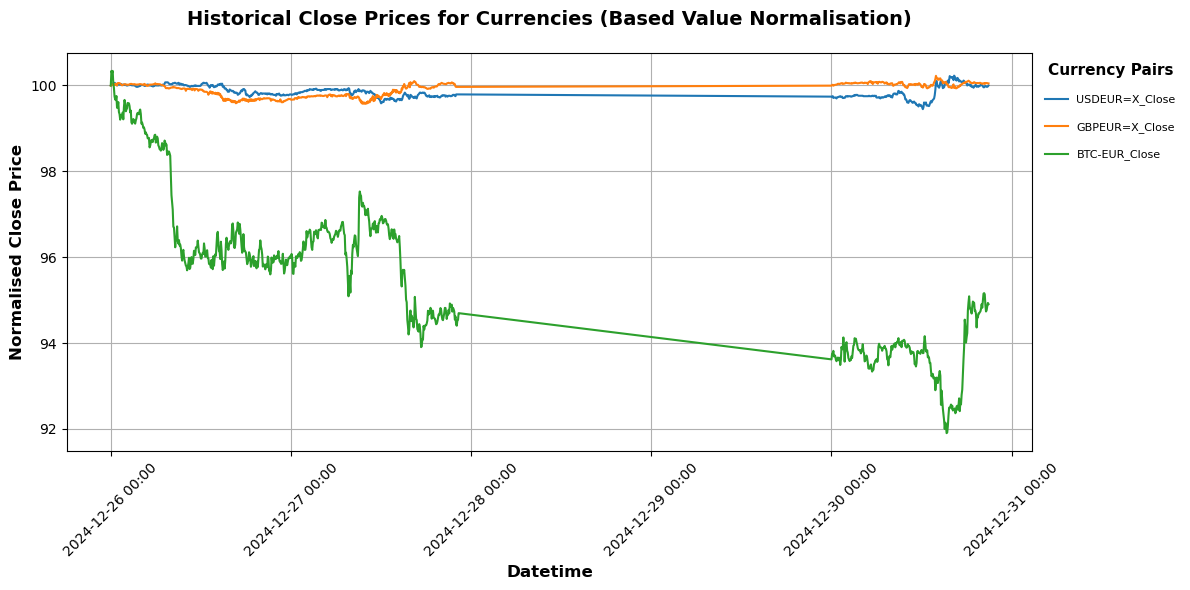

In [26]:
plotClosePrices(normalisedBasedValue5d, title='Historical Close Prices for Currencies (Based Value Normalisation)')

The British Pound (GBP) has shown a relatively stable trend against the Euro (EUR), with only minor fluctuations. This stability may reflect the overall economic steadiness of the UK and the Eurozone during this period, with no major disruptions or events significantly affecting the exchange rate.

Similarly, the USDEUR=X_Close, covering the past five days, demonstrates a normalised pattern similar to GBPEUR. This suggests that the USD has remained relatively stable against the Euro in the short term, likely indicating a lack of significant economic disturbances in both the US and the Eurozone.

In contrast, BTC-EUR_Close exhibits considerable volatility over the same five-day period, which is typical for Bitcoin and other cryptocurrencies. Such fluctuations are common due to the inherent volatility of cryptocurrencies, which are more susceptible to market sentiment and external influences.

In summary, the fiat currency pairs (GBPEUR and USDEUR) show a pattern of stability. In contrast, the BTC-EUR pair is more volatile, highlighting the contrasting nature of traditional currencies versus digital assets.

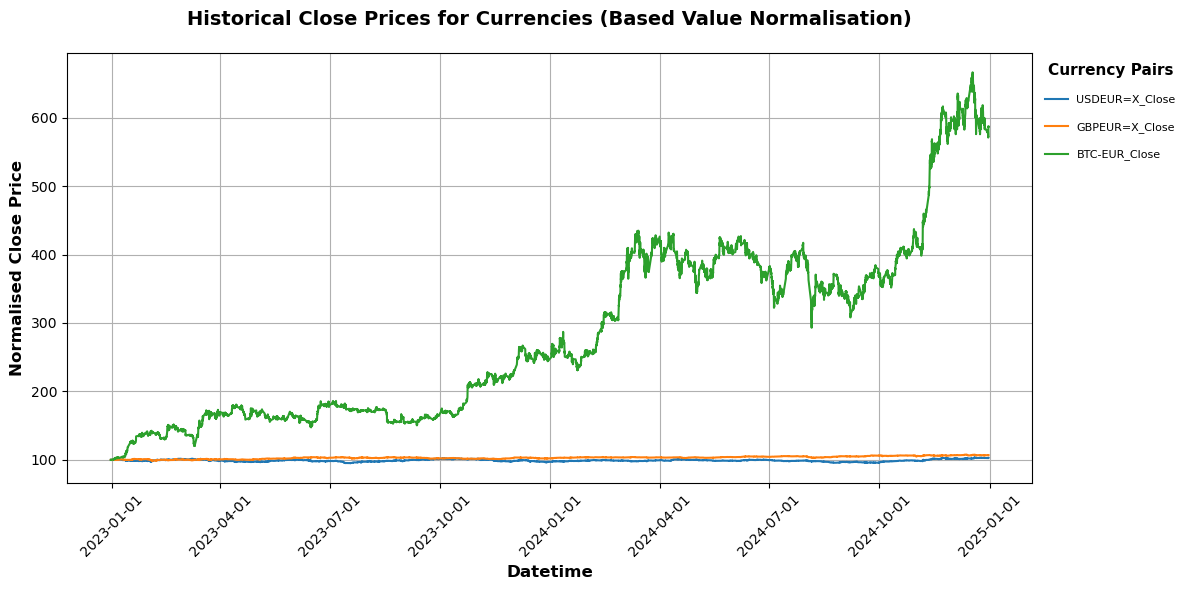

In [27]:
plotClosePrices(normalisedBasedValue2y, title='Historical Close Prices for Currencies (Based Value Normalisation)')

The USDEUR=X_Close, represented by the blue line, has remained relatively stable for the two years with only minor fluctuations around the base value 100. This stability indicates that the exchange rate between the USD and EUR has not seen any significant turmoil, signalling steady economic conditions in the United States and the Eurozone. There have been slight ups and downs; however, the overall series trend reflects a stable relationship between the two currencies.

 Similarly, the GBPEUR=X_Close, in orange, also reflects stability. The normalised prices do not deviate much from the base value of 100, which means that the exchange rate between the British Pound and the Euro has remained relatively stable over the last two years. Such stability indicates that no significant events have occurred that disrupted the GBP and EUR exchange rate.

On the other hand, BTC-EUR_Close is quite different, having started at the base value of 100 and tending to increase enormously, reaching over 600 up to the end of two years. Such a rapid rise is indicative of volatility and growth potential for Bitcoin against traditional fiat currencies. The huge appreciation of Bitcoin against the Euro indicates growing adoption and enthusiasm for cryptocurrencies and their inherent volatility.

Whereas the trending slopes of USD-EUR and GBP-EUR fiat pairs are relatively stable and close together, the pair BTC-EUR uncovers tremendous growth and, thus, volatility. This might confirm the distinctive market forces driving traditionally driven currencies versus modern cryptocurrency alternatives.

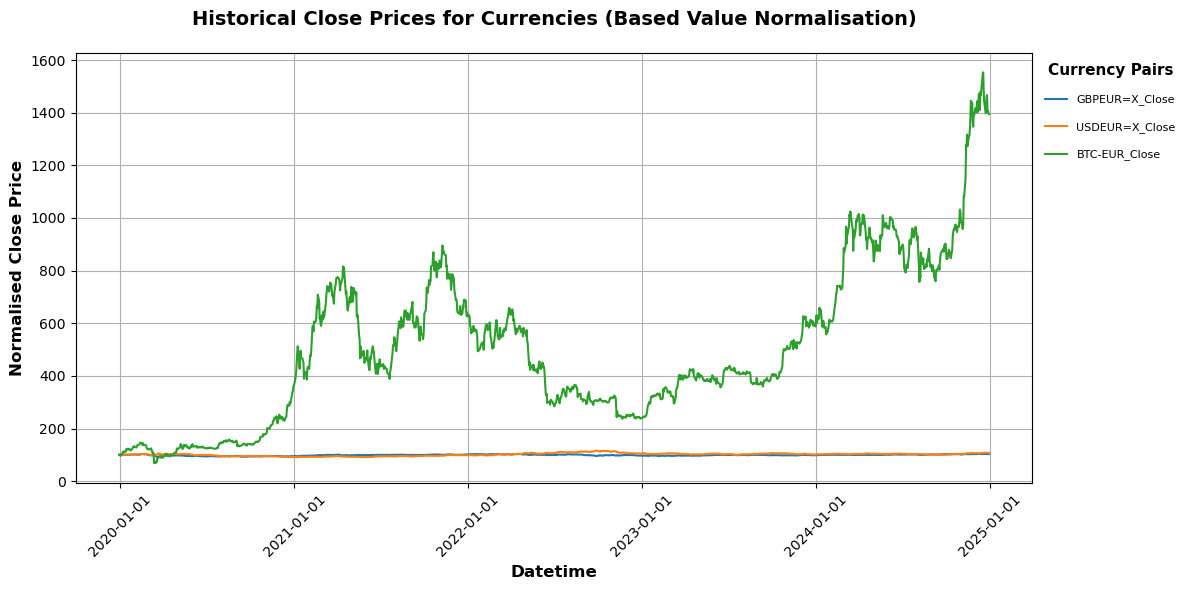

In [28]:
plotClosePrices(normalisedBasedValue5y, title='Historical Close Prices for Currencies (Based Value Normalisation)')

Over the five years, the behaviour of each currency pair gives an interesting insight into their respective trends and volatility since all data was normalized using the same method.
It can be seen from historical data that USDEUR=X_Close (Blue Line) has a quite stable trend line with small fluctuations above or below the base value of 100. In itself, this stability can reflect that over the five years, the exchange rate has been consistent between USD and EUR, with no huge disruptions in the market, which have caused large shifts. It may indicate a certain regularity in the development between the economies of the United States and those within the Eurozone area.

The same trend is shown by the GBPEUR=X_Close, orange line, which reflects a normalized price that has kept almost near the base value of 100. This means the rate of exchange between GBP and EUR has been quite stable between the UK and the Eurozone economies. Of course, slight changes happened, but nothing too extreme; hence, this currency pair was calm during these five years.

On the other hand, BTC-EUR_Close paints a different story altogether. Starting at the base value of 100, the normalized price for BTC-EUR has been very volatile and shows, in general, an upward trend, going over 1600 by the end of the period. This dramatic increase highlights the high volatility and growth potential that Bitcoin offers compared to more traditional fiat currencies. The sharp rise in the value of Bitcoin against the Euro is a reflection of the wider adoption and market fervour for cryptocurrencies, coupled with the high volatility that is characteristic of them.

The above graph succinctly captures that, while the fiat currency pairs are stable and show consistent upward trends in the five years, the BTC-EUR pair has huge growth with high volatility, underlining the different market dynamics between traditional currencies and cryptocurrencies. This plot offers an overall look at how these currency pairs have behaved on an extended timescale and provides a valuable insight into their respective trends and market conditions.

***

 Next, a line plot is generated for Min-Max Normalisation.

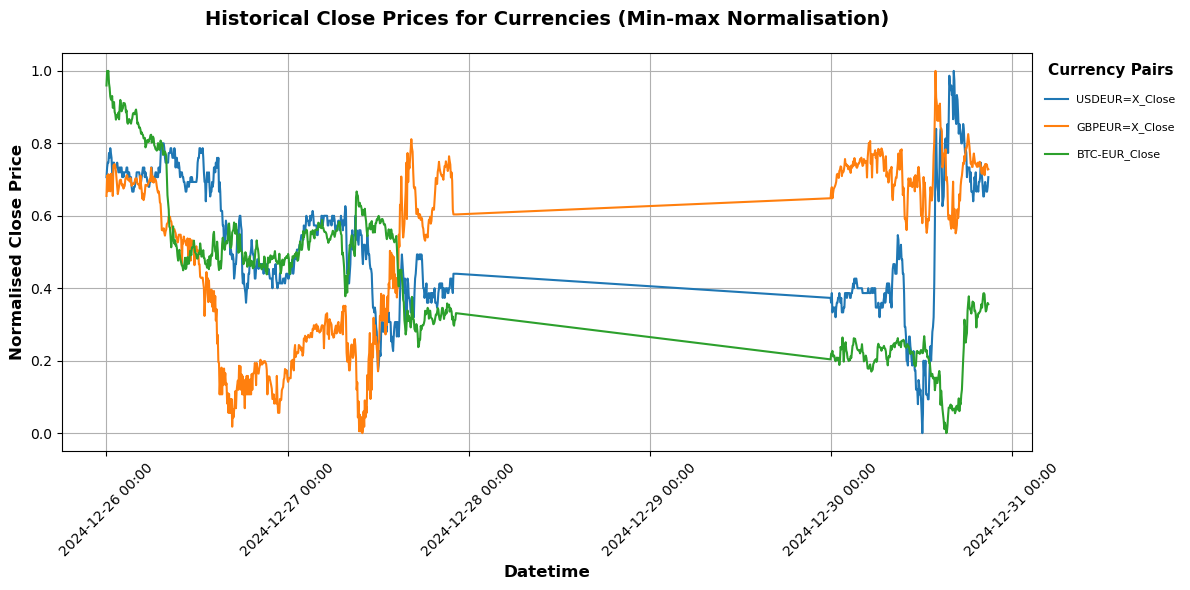

In [29]:
plotClosePrices(normalisedMinMax5d, title='Historical Close Prices for Currencies (Min-max Normalisation)')

Over the five days, the data normalized using the min-max method provides a clear view of the trends and volatility for each currency pair.

Considering first the GBPEUR=X_Close (blue line), notice the trend over history, relatively smooth with minor fluctuations around the normalized value. This indicates stability in the exchange rate of the GBP against the EUR over these five days; this means that during the period under consideration, there were no huge shocks either in the UK or in the Eurozone economy.

The pattern in USDEUR=X_Close follows small changes, while the orange line is pretty stable near the base value. Similarly, the rate of the USD against the EUR has remained relatively stable, indicating stable economic times for both the United States and the Eurozone over the period in question. The nature of currency trading has small fluctuations that do not reveal major economic events affecting this pair.

On the other hand, BTC-EUR_Close shows more pronounced volatility. From the base-normalized value, Bitcoin closing prices against the Euro show huge fluctuations, reflecting their usually inherent volatility and dynamic nature.

Overall, this graph portrays the peculiar behaviours of the fiat currency pairs and that of a cryptocurrency pair over the short term. Whereas the GBPEUR and USDEUR pairs are relatively stable and reflect only minor fluctuations, the BTC-EUR pair represents extreme volatility, therefore underlying different market dynamics and behaviours between traditional currencies and cryptocurrencies. This analysis provides valuable insight into recent trends and conditions of these currency pairs.


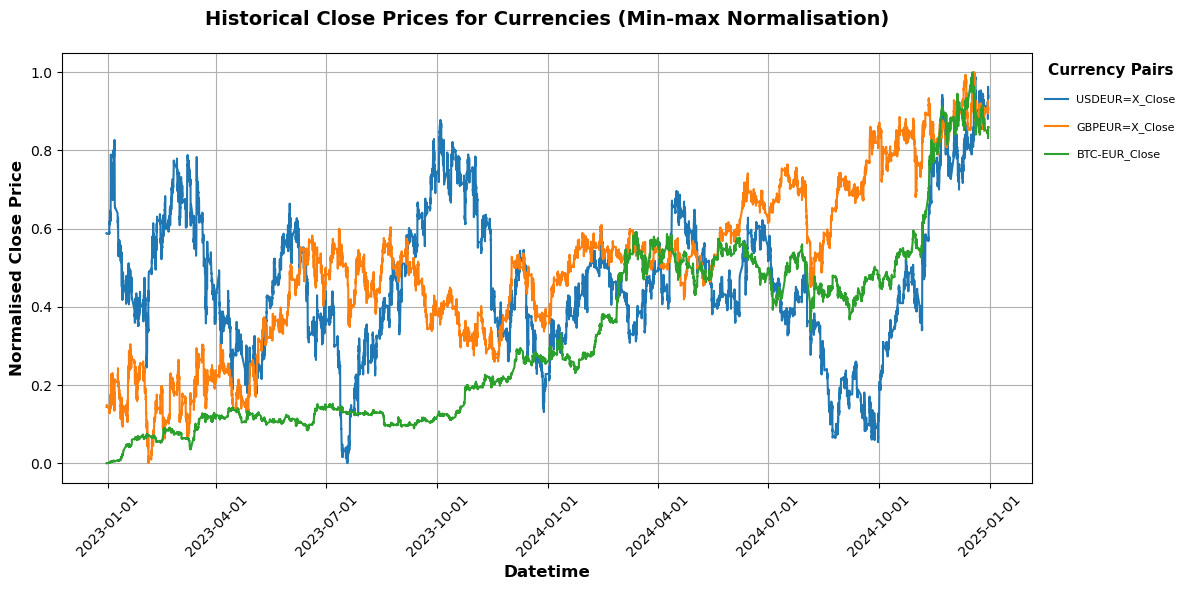

In [30]:
plotClosePrices(normalisedMinMax2y, title='Historical Close Prices for Currencies (Min-max Normalisation)')

In the min-max normalization method, the range of normalized closing prices is shown over two years, showing trends and volatility for each currency pair.

First, the USDEUR=X_Close, represented by the blue line, shows quite a stable trend with minor deviations from the normalized value. The such stability of this currency pair points to the fact that in these two years, the USD/EUR exchange rate stood stable, reflecting stable economic conditions in the United States and the Eurozone without huge interruptions or market shocks. The deviations are minor. Hence, this economic relationship between the regions was all regular and predictable.

The orange line of the GBPEUR=X_Close also follows a rather stable path, with its normalized prices hovering close to the base value. The exchange rate between GBP and EUR has been quite steady, signalling a calm economic condition in the UK and the Eurozone over the observed period. The minor fluctuations are typical in currency trading but do not point to any major economic events for this pair. The continuity of this trend indicates the steadiness of the period, economically, for the UK and Eurozone, with no wide variations in the exchange rate.

This is in high contrast to the BTC-EUR_Close in green, which is quite volatile. Bitcoin's close against the Euro reflects substantial fluctuation, a typical level of volatility, and dynamic change found across most digital cryptocurrencies. Indeed, such reflects the overall action of late with Bitcoin, its value suddenly leaping upwards and plummeting based upon market sentiment on rumours regarding regulation and wider adoption. This more than two-fold increase in Bitcoin's value within two years underlines the great interest and adoption on the market but also shows how volatile such an investment might be.

The graph generally covers the different behaviours the pairs of fiat currency and cryptocurrency have during a longer time. Thus, USD-EUR and GBP-EUR are relatively stable and take small fluctuations. BTC-EUR shows high volatility and more significant growth potential, reflecting the difference in market dynamic behaviour and relationships between traditional and new money. This provides us with valuable insights into the tendencies and market conditions of the currency pairs during the two years.

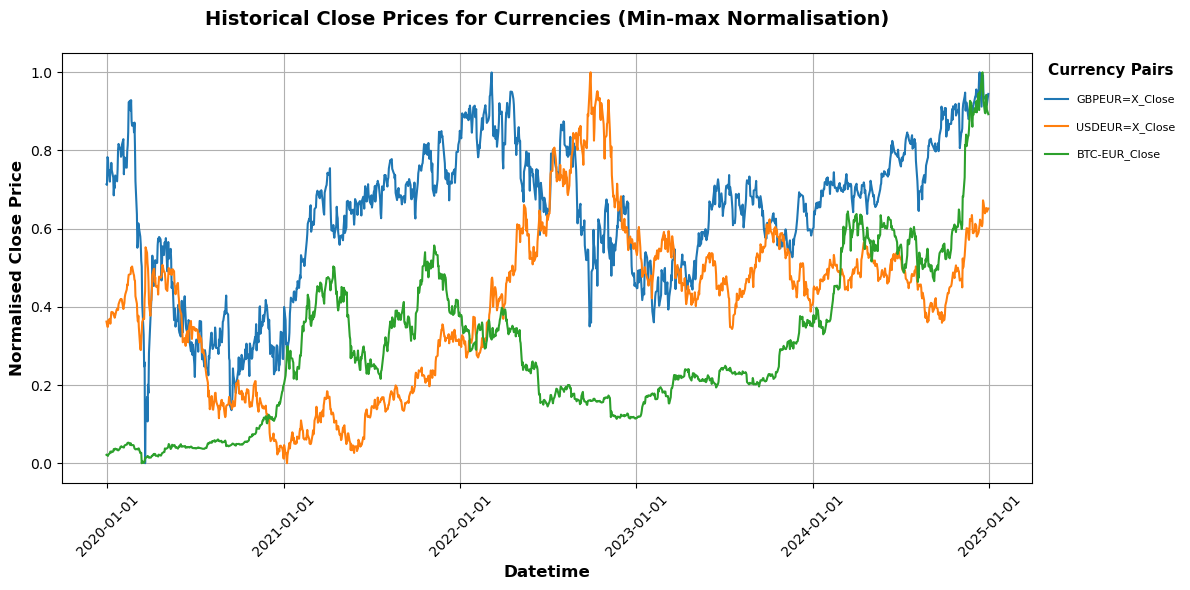

In [31]:
plotClosePrices(normalisedMinMax5y, title='Historical Close Prices for Currencies (Min-max Normalisation)')

Let's start with USDEUR=X_Close, depicted by the blue line. It has shown quite stable behaviour, within small fluctuations around the normal value. Such stability within these five years may indicate that over these years, USD to EUR exchange rates have remained consistent and that economic scenarios in the US and the Eurozone have been undisturbed, showing no great economic shocks or market disruptions. The minor fluctuations characterize a regular, predictable pattern in the economic relationship between these regions.

GBPEUR=X_Close moves along a flat path, and the normalized prices hover near the base value. Therefore, during the period concerned, the exchange rate of GBP versus EUR was almost stable, indicating calm conditions in the UK and Eurozone economies. Whatever small fluctuations were there, it was normally present in any currency trading, and is too minimal to indicate that any big economic event affects this currency pair. This is indicative of the fact that the tendency has been quite stable without serious changes in the exchange rate both for the UK and the Eurozone.

In contrast, BTC-EUR_Close, depicted by the green line, shows high volatility. Starting off from the base normalized value, Bitcoin's closing prices against the Euro have followed wild ups and downs to reflect a general volatility characteristic of cryptocurrency. This certainly agrees with the known nature of Bitcoin, whose value typically goes up or down at neck-breaking speeds depending on sentiments in the market, news about regulatory actions, and overall adoption rates. The high growth in the value of Bitcoin over the five years shows high market interest and adoption, but its volatility points to the risks of investing in cryptocurrency.

The graph below gives the behaviour of fiat currency pairs and cryptocurrency pairs over an extended period. Overall, USD-EUR and GBP-EUR are showing the least fluctuation, while BTC-EUR expresses significant volatility and growth potential-to show the difference in the market dynamic and behavior for traditional currencies from their crypto-currencies. This shall provide trends and market conditions regarding these currency pairs over the five years.


***

 Finally, a line plot is created for Z-Score Normalisation.

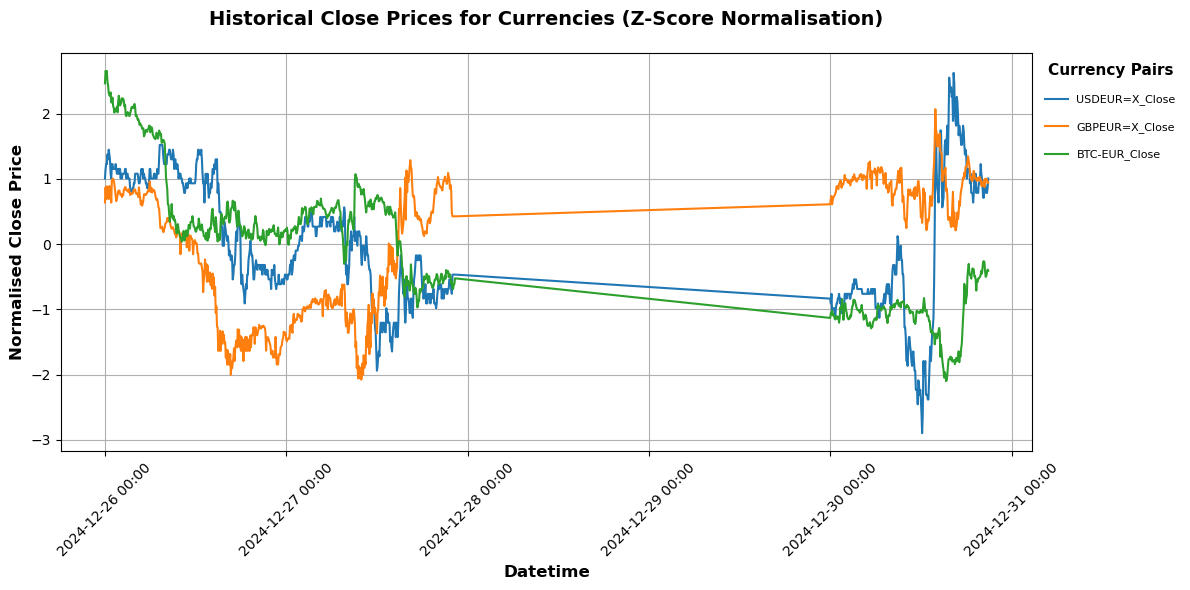

In [32]:
plotClosePrices(normalisedZscore5d, title='Historical Close Prices for Currencies (Z-Score Normalisation)')

The blue line, which represents the GBPEUR=X_Close, shows stability in the trend with minor fluctuations within the five days. This means stable economic conditions in the UK and the Eurozone, with no disruptions that would have impacted the exchange rate between the GBP and EUR.

The USDEUR=X_Close in orange also indicates stability with slight fluctuations, which means consistent economic conditions between the US and the Eurozone, and thus, a steady relationship between USD and EUR within the period observed.

At the same time, BTC-EUR_Close (green line) is highly volatile. It shows that cryptocurrencies are dynamic and unpredictable versus their fiat currency pairs, meaning that they move very fast in value due to mass sentiment and other outside factors.

The plot below captures the peculiar behaviours of fiat currency pairs and a cryptocurrency pair over a short period. The pairs GBP-EUR and USD-EUR are relatively stable with minor fluctuations. The pair BTC-EUR acts highly volatile, reflecting the different market dynamics of traditional currencies versus cryptocurrencies. This analysis thus provides these currency pairs' recent trends and market conditions.

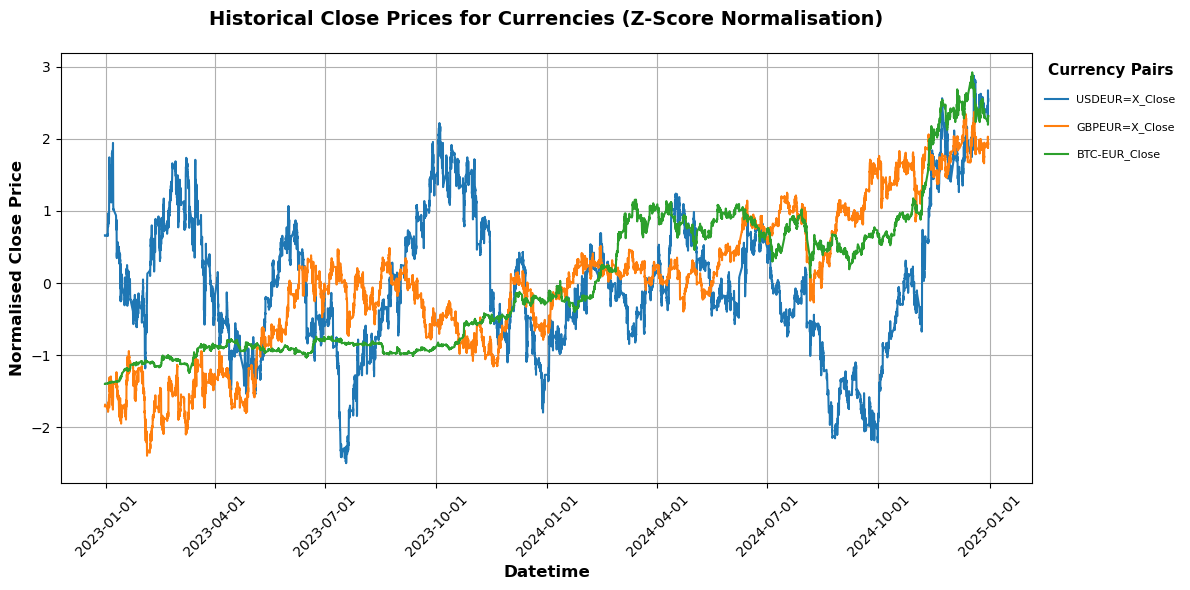

In [33]:
plotClosePrices(normalisedZscore2y, title='Historical Close Prices for Currencies (Z-Score Normalisation)')

Over the two years, USDEUR=X_Close appears very stable, with minor fluctuations; this reflects the same stability in economic conditions between the US and the Eurozone, which has not suffered from any disruption in the exchange rate between the USD and EUR.

The GBPEUR=X_Close also shows stability with slight fluctuations, suggesting steady economic conditions in the UK and Eurozone. That means it keeps the same pace on exchange rates between GBP and EUR.

On the other side is huge volatility by BTC-EUR_Close, reflecting how volatile cryptocurrencies can be against their fiat pairs.


In general, both pairs of currencies, the USD-EUR and GBP-EUR, demonstrate slight deviations in stability, while the BTC-EUR pair is highly volatile. Such a difference reflects various market dynamics between traditional and digital currencies. Given that, the following analysis will give a view of the tendencies in the market conditions of the given currency pairs for two years.


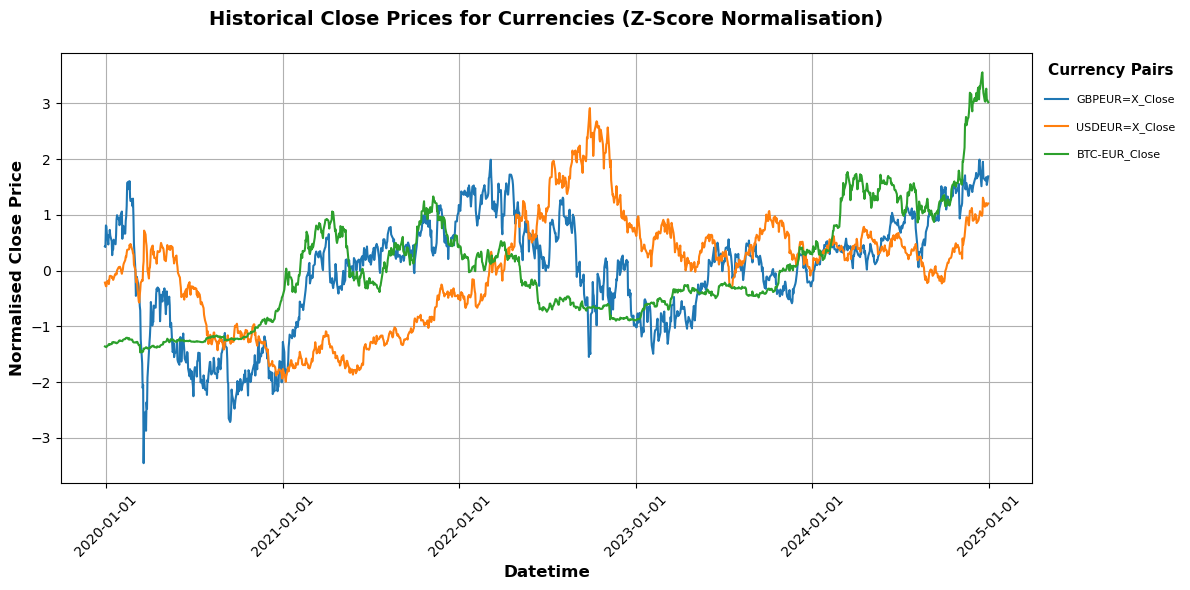

In [34]:
plotClosePrices(normalisedZscore5y, title='Historical Close Prices for Currencies (Z-Score Normalisation)')

Applying the Z-Score normalization method normalizes the closing prices over five years and gives a better view of the trend and volatility for each currency pair.

The USDEUR=X_Close (blue line) shows a stable trend with minor fluctuations. This stability could mean that, over the past five years, the exchange rate between the USD and the EUR has been consistent, reflecting similar economic conditions in both the United States and the Eurozone, with no significant disruption to the markets that resulted in major shifts.

On the other hand, the GBPEUR=X_Close is stable, taking in slight fluctuations. This might mean the UK and the Eurozone have had relatively stable economic conditions from the period observed.

The BTC-EUR_Close, in green, is highly volatile. From this base-normalized value, Bitcoin's closing prices against the Euro have seen extreme swings, reflecting the dynamic and unpredictable nature of cryptocurrencies. This is typical behaviour by Bitcoin and usually emanates from market sentiment, regulatory news, and broader adoption trends.

Meanwhile, the pairs of USD-EUR and GBP-EUR were stable, changing no more than by several percent, and the pair of BTC-EUR-very strongly volatile. This actually brings a different market dynamic between the traditional fiat currencies and cryptocurrencies, providing, in turn, quite useful insights into their respective trends and market conditions over the five years.

***

#### Computing descriptive statistics such as each currency's mean, median, standard deviation, and range.


**Descriptive Statistics for Normalised Data**

To analyse the normalised datasets comprehensively, we calculate the following statistics for each currency (USD-EUR, GBP-EUR, and BTC-EUR) across different normalisation methods (Based Value, Min-Max, and Z-Score) and time periods (5 days, 2 years, and 5 years):

1. **Mean**: Represents the average normalised value, providing insight into the central tendency.
2. **Median**: Highlights the middle value, which is unaffected by extreme values, offering robustness against outliers.
3. **Standard Deviation**: Measures variability, indicating the consistency or volatility in the data.
4. **Range**: Captures the spread (difference between the maximum and minimum values) to visualise the extent of fluctuations.

In [35]:
# List of DataFrames
columnsOfInterest = ['USDEUR=X_Close', 'GBPEUR=X_Close', 'BTC-EUR_Close']

# Generate statistics for different datasets
normalisedBasedValue2yStatistics = descriptiveStatisticsWithSource(normalisedBasedValue2y, columnsOfInterest, "normalisedBasedValue2y")
normalisedBasedValue5yStatistics = descriptiveStatisticsWithSource(normalisedBasedValue5y, columnsOfInterest, "normalisedBasedValue5y")
normalisedBasedValue5dStatistics = descriptiveStatisticsWithSource(normalisedBasedValue5d, columnsOfInterest, "normalisedBasedValue5d")
normalisedMinMax2yStatistics = descriptiveStatisticsWithSource(normalisedMinMax2y, columnsOfInterest, "normalisedMinMax2y")
normalisedMinMax5yStatistics = descriptiveStatisticsWithSource(normalisedMinMax5y, columnsOfInterest, "normalisedMinMax5y")
normalisedMinMax5dStatistics = descriptiveStatisticsWithSource(normalisedMinMax5d, columnsOfInterest, "normalisedMinMax5d")
normalisedZscore2yStatistics = descriptiveStatisticsWithSource(normalisedZscore2y, columnsOfInterest, "normalisedZscore2y")
normalisedZscore5yStatistics = descriptiveStatisticsWithSource(normalisedZscore5y, columnsOfInterest, "normalisedZscore5y")
normalisedZscore5dStatistics = descriptiveStatisticsWithSource(normalisedZscore5d, columnsOfInterest, "normalisedZscore5d")


The decision has been made to merge all the data into one DataFrame.

In [36]:
# Merge all data into a single DataFrame
descriptiveStatistics = pd.concat([normalisedBasedValue2yStatistics, normalisedBasedValue5yStatistics, normalisedBasedValue5dStatistics,\
                              normalisedMinMax2yStatistics, normalisedMinMax5yStatistics, normalisedMinMax5dStatistics,\
                              normalisedZscore2yStatistics, normalisedZscore5yStatistics, normalisedZscore5dStatistics], ignore_index=True)

The decision has been made to save the merged data to the CSV file for future use.

In [37]:
# Save the merged statistics to a CSV file
descriptiveStatistics.to_csv('data/csv/statistics/descriptiveStatistics.csv', index=False)

The decision has been made to transfer the merged data to the DataBase.

In [38]:
# Transfer the data to SQLite database
conn = sqlite3.connect('data/db/currencies.db')
descriptiveStatistics.to_sql('descriptiveStatistics', conn, if_exists='replace', index=False)
conn.close()


To filter data from a new DataFrame, conditional selection can be used based on column values, such as filtering by the 'source' column.

In [39]:
normalisedBasedValue5dnew = descriptiveStatistics[descriptiveStatistics['source'] == 'normalisedBasedValue5d']
normalisedBasedValue5dnew

,column,source,description,median,mean,standardDeviation,range
6,USDEUR=X_Close,normalisedBasedValue5d,Exchange rate of USD to EUR,99.833556,99.858176,0.141395,0.780199
7,GBPEUR=X_Close,normalisedBasedValue5d,Exchange rate of GBP to EUR,99.955215,99.900168,0.157167,0.651024
8,BTC-EUR_Close,normalisedBasedValue5d,Exchange rate of BTC to EUR,95.863997,95.629798,1.776387,8.438642


All the DataFrame will be shown.

In [40]:
descriptiveStatistics

,column,source,description,median,mean,standardDeviation,range
0,USDEUR=X_Close,normalisedBasedValue2y,Exchange rate of USD to EUR,98.822146,9.897024e+01,1.555098,8.352073
1,GBPEUR=X_Close,normalisedBasedValue2y,Exchange rate of GBP to EUR,103.278773,1.032155e+02,1.881412,8.977217
2,BTC-EUR_Close,normalisedBasedValue2y,Exchange rate of BTC to EUR,253.042082,2.831198e+02,131.134420,566.297576
3,USDEUR=X_Close,normalisedBasedValue5y,Exchange rate of USD to EUR,102.179992,1.011368e+02,5.285788,25.918353
4,GBPEUR=X_Close,normalisedBasedValue5y,Exchange rate of GBP to EUR,99.416143,9.895211e+01,2.427365,13.205372
5,BTC-EUR_Close,normalisedBasedValue5y,Exchange rate of BTC to EUR,430.956137,5.021912e+02,295.871394,1485.158231
6,USDEUR=X_Close,normalisedBasedValue5d,Exchange rate of USD to EUR,99.833556,9.985818e+01,0.141395,0.780199
7,GBPEUR=X_Close,normalisedBasedValue5d,Exchange rate of GBP to EUR,99.955215,9.990017e+01,0.157167,0.651024
8,BTC-EUR_Close,normalisedBasedValue5d,Exchange rate of BTC to EUR,95.863997,9.562980e+01,1.776387,8.438642
9,USDEUR=X_Close,normalisedMinMax2y,Exchange rate of USD to EUR,0.447436,4.651675e-01,0.186193,1.000000


The mean values for all different normalisations are taken as representatives of the average level of the exchange rate, while the median provides information about the central value of this distribution that does not depend on extreme values or outliers. This gives a better and more robust estimator of its centrality. Taking into consideration that, given the few outliers in certain variables, the median might remain without variations while having slight modifications in the mean value.

Standard deviation is one of the key volatility measures that show how individual observations are falling away from the mean. The greater the standard deviation, the more volatile the currency, and this is highly represented in BTC-EUR compared to other traditional currencies, USD-EUR and GBP-EUR. Standard deviations across the datasets are large, showing that BTC-EUR has a big variability, especially for larger time horizons, which is typical for high-risk and speculative cryptocurrency markets.

The range between the maximum and the minimum value underpins the degree of fluctuation experienced in the datasets even more. Of these, some pairs will have a wider range for values, indicating dramatic swings in the exchange rate-such as BTC-EUR-and some will have a narrow value range, which would express the traditional currency pairs that have more stable behaviour along the observed periods, as with USD-EUR and GBP-EUR.

During normalisation, values lie in the range between 0 and 1 in the perspective of Min-Max normalisation, which can indicate comparatively the movement within the recorded time. 
Precisely, the Z-score normalisation of data around the mean with zero and variance of the unit helps to know how far the points might have fallen away from their mean, which also signifies extraordinary or extreme movements. For instance, negative Z-scores in BTC-EUR and USD-EUR for different periods show the points where the exchange rate fell below the expected normality.
In the case of the Based Value normalisation, the data is referenced to a baseline; therefore, comparisons over time can be drawn. The median, mean, and other statistical measures enable analysts to spot trends, anomalies, and periods of high volatility or stability. A combined analysis of such indicators enables drawing conclusions on general characteristics of the dynamics within the foreign exchange market, defining the pattern of fluctuation and the relative stability of each currency in longer and shorter time frames.

Overall, the statistics show that while the traditional currency pairs behave relatively stable in the USD-EUR and GBP-EUR exchange rates, the BTC-EUR exchange rate shows significant volatility and fluctuation-perhaps something that might come with the expectation of virtual cryptocurrency markets. These statistics measures, therefore, enable a better understanding of the exchange rate dynamics and pinpoint key periods of stability or volatility, besides placing data in its essential context for market analysis.


***

#### Exploring relationships between currencies using correlation matrices and heatmaps.

Based on the [Datacamp website](https://www.datacamp.com/tutorial/tutorial-datails-on-correlation) definition of correlation is: Correlation is a way to analyse the connection or association between two variables. It helps us understand the relationship between two sets of variables, how strong it is, and in what direction.

Correlation is crucial for data exploration, real-world applications, and machine learning. It helps us understand data characteristics, answer questions, and address multicollinearity issues. Multicollinearity is when an independent variable is highly correlated with another variable in multiple regression, which undermines its statistical significance. Additionally, correlation is essential for Principal Component Analysis (PCA), a valuable technique in machine learning projects, which is understood as a technique for reducing the number of dimensions in a dataset while retaining the most important information

There are different types of correlation:

* Positive correlation occurs when two variables move in the same direction. For instance, as X increases, Y also increases consistently.
* Neutral correlation is when here is no connection between the changes in variables X and Y. The values are entirely random and do not exhibit any correlation.
* Negative correlation is when variables X and Y change values in opposite directions. This means that as the value of X goes up, the value of Y consistently goes down.

The correlation coefficient quantifies the strength and direction of the relationship between two 
variables. Correlation coefficients provide a standardized measure of the relationship between two variables. 
They always fall within the range of -1.0 to 1.0. We can choose from the few correlation coefficients 
depending on our knowledge of the relationship between variables. Data scientists prefer using Pearson's 
correlation coefficient, the most well-known option.

Understanding the coefficient can be challenging, especially when it is close to zero. Using the table below can help interpret the coefficient's values.

| Size of Correlation                  | Interpretation                            |
|--------------------------------------|-------------------------------------------|
|  0.90 to 1.00 (-0.90 to -1.00)       | Very high positive (negative) correlation |
|  0.70 to 0.90 (-0.70 to -0.90)       | High positive (negative) correlation      |
|  0.50 to 0.70 (-0.50 to -0.70)       | Moderate positive (negative) correlation  |
|  0.30 to 0.50 (-0.30 to -0.50)       | Low positive (negative) correlation       |
|  0.00 to 0.30 (0.00 to -0.30)        | Little if any correlation                 |

When Pearson's correlation coefficient is close to 0.0, it simply means there isn't a linear connection between the two variables. However, there could still be a strong non-linear relationship present. With a non-linear relationship, the rate of change in one variable may vary as the other variable changes, resulting in a curve-like pattern in the data. Like a quadratic or cubic function, a non-linear function more accurately represents this trend.

A scatter plot or a heatmap represents the correlation. In this case, a heatmap is chosen to recognise the result quickly. A specially designed function is used to create plots.

***

The correlation of the currency exchange rates normalised by the Based Value method over 5 days.

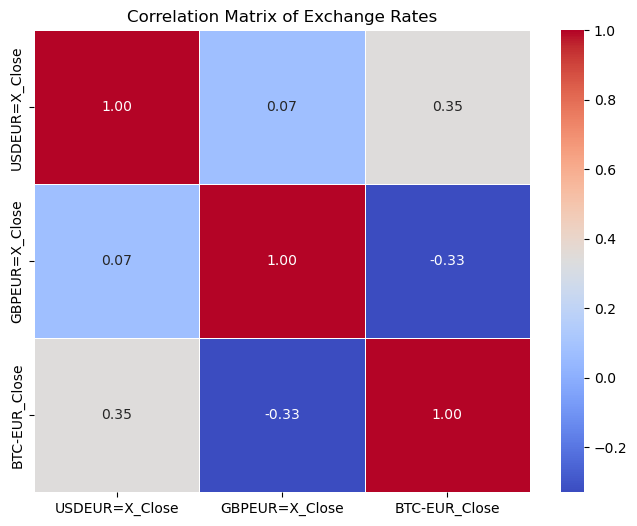

In [42]:
plotCorrelationMatrix(normalisedBasedValue5d, 
                      columns=['USDEUR=X_Close', 'GBPEUR=X_Close', 'BTC-EUR_Close'], 
                      title='Correlation Matrix of Exchange Rates')


The correlation of the currency exchange rates normalised by the Based Value method over 2 years.

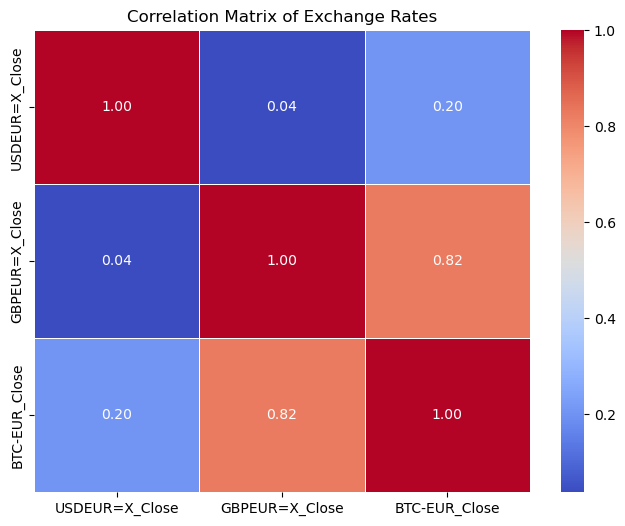

In [43]:
plotCorrelationMatrix(normalisedBasedValue2y,
                      columns=['USDEUR=X_Close', 'GBPEUR=X_Close', 'BTC-EUR_Close'], 
                      title='Correlation Matrix of Exchange Rates')


The correlation of the currency exchange rates normalised by the Based Value method over 5 years.

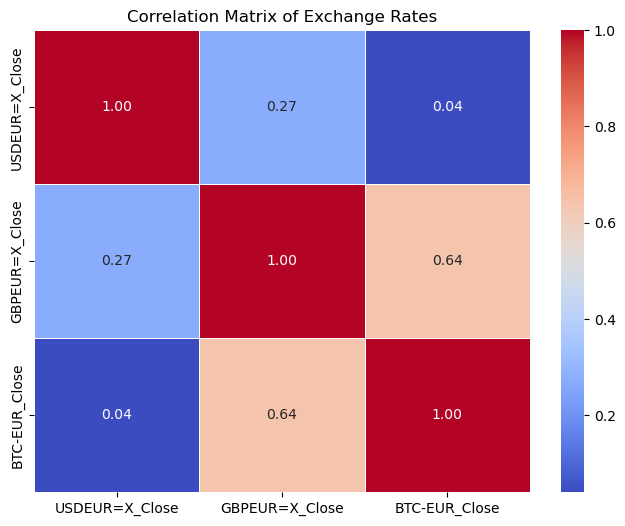

In [44]:
plotCorrelationMatrix(normalisedBasedValue5y,
                      columns=['USDEUR=X_Close', 'GBPEUR=X_Close', 'BTC-EUR_Close'], 
                      title='Correlation Matrix of Exchange Rates')


The correlation of the currency exchange rates normalised by the Min-Max method over 5 days.

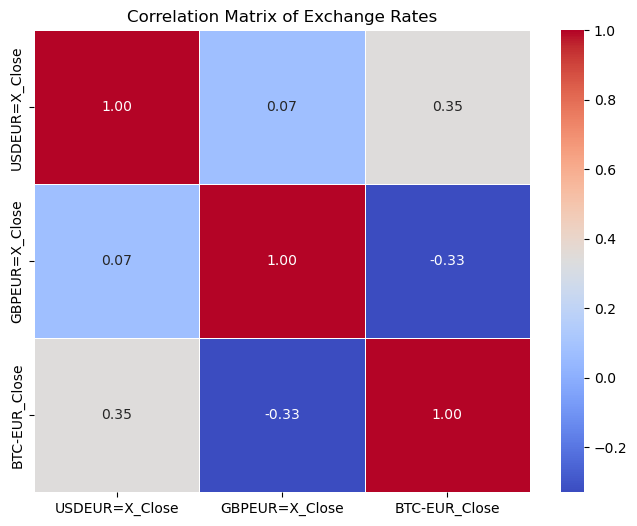

In [45]:
plotCorrelationMatrix(normalisedMinMax5d,
                      columns=['USDEUR=X_Close', 'GBPEUR=X_Close', 'BTC-EUR_Close'], 
                      title='Correlation Matrix of Exchange Rates')


The correlation of the currency exchange rates normalised by the Min-Max method over 2 years.

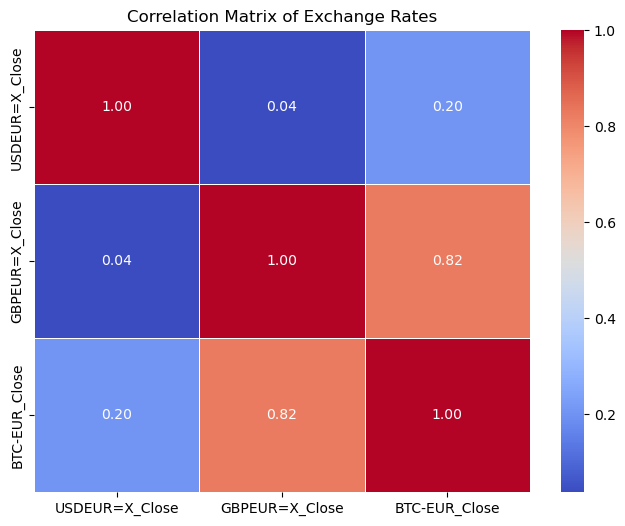

In [46]:
plotCorrelationMatrix(normalisedMinMax2y,
                      columns=['USDEUR=X_Close', 'GBPEUR=X_Close', 'BTC-EUR_Close'], 
                      title='Correlation Matrix of Exchange Rates')


The correlation of the currency exchange rates normalised by the Min-Max method over 5 years.

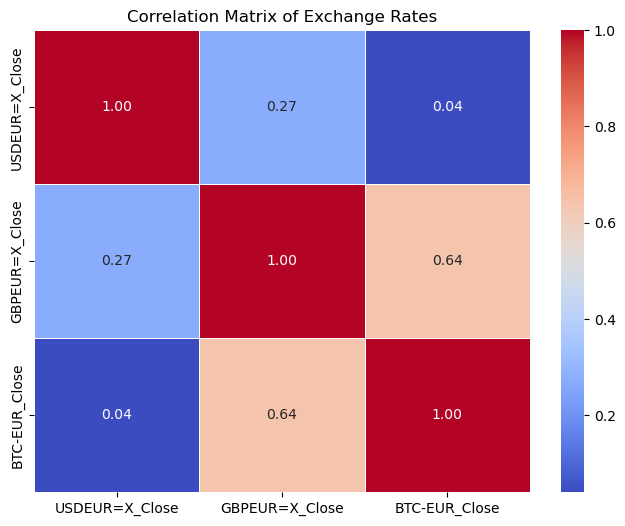

In [47]:
plotCorrelationMatrix(normalisedMinMax5y,
                      columns=['USDEUR=X_Close', 'GBPEUR=X_Close', 'BTC-EUR_Close'], 
                      title='Correlation Matrix of Exchange Rates')
